<a href="https://colab.research.google.com/github/sfarias03/Water-Quality-/blob/main/SF_Well_Switching_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction


This project builds upon an analysis of a public health study conducted in rural Bangladesh (Gelman et al., 2004). The study examined arsenic contamination in drinking water wells and whether households switched wells. We measured several variables thought to influence well-switching decisions. Our goal is to predict household well-switching accurately based on these variables. The study collected data on arsenic levels (in hundreds of 𝜇g/L) in Araihazar, Bangladesh during 1999-2000. Additional information was obtained through a survey, including well-switching, distance to the nearest safe well, household involvement in community organizations, and highest education level. Arsenic contamination in drinking water is a global concern, affecting over 140 million people in 50 countries above the WHO guideline of 10 μg/L, with associated health risks (WHO, 2018a).


## Import libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# plot tree model
import graphviz

# Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Train-test splits and cross validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn import tree
import xgboost as xgb

# Model metrics
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

from scipy.stats import uniform, randint


# Logistic function
from scipy.special import expit

## Load the data

In [29]:
df = pd.read_csv('https://raw.githubusercontent.com/sfarias03/Water-Quality-/main/wells.csv')

## Explore the contents of the data sets

$\rightarrow$ Look at the head of the data frame.


In [30]:
df.head()

,switch,arsenic,dist,assoc,educ
0,1,2.36,16.826000,0,0
1,1,0.71,47.321999,0,0
2,0,2.07,20.966999,0,10
3,1,1.15,21.486000,0,12
4,1,1.10,40.874001,1,14


In [31]:
df.describe()

,switch,arsenic,dist,assoc,educ
count,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000
mean,0.575166,1.656930,48.331863,0.422848,4.828477
std,0.494400,1.107387,38.478675,0.494093,4.017317
min,0.000000,0.510000,0.387000,0.000000,0.000000
25%,0.000000,0.820000,21.117250,0.000000,0.000000
50%,1.000000,1.300000,36.761499,0.000000,5.000000
75%,1.000000,2.200000,64.041000,1.000000,8.000000
max,1.000000,9.650000,339.531006,1.000000,17.000000


The variables in the data set are:

1. `switch`: An indicator of whether a household switches wells.

2. `arsenic`: The arsenic level of the household's well (in hundreds $\mu$g/L).

3. `dist`: The distance (in meters) to the closest known safe well.

4. `assoc`: An indicator of whether any members of the household are involved in community organizations.

5. `educ`: The highest education level in the household.
  
  

$\rightarrow$ Check the data types. How many observations are in the data set? How many missing values are there in each column?


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   switch   3020 non-null   int64  
 1   arsenic  3020 non-null   float64
 2   dist     3020 non-null   float64
 3   assoc    3020 non-null   int64  
 4   educ     3020 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 118.1 KB


In [33]:
df.isna().sum()

switch     0
arsenic    0
dist       0
assoc      0
educ       0
dtype: int64

## Rename columns or values to follow best practices

In [35]:
df.columns

Index(['switch', 'arsenic', 'dist', 'assoc', 'educ'], dtype='object')

In [36]:
df.rename(columns={'switch':'switch_well', 
                   'dist':'distance_in_meters', 
                   'assoc':'organization_member', 
                   'educ':'education_years'}, inplace=True)

In [37]:
df['organization_member'].value_counts()

0    1743
1    1277
Name: organization_member, dtype: int64

## Create relevant derived variables as new columns

We may already know that we want to process the data to create new variables from the existing variables. However, we often start analyzing the data and realize that it is useful to create new variables derived from the existing variables. It is fine to return to modify this step after exploring the data further.

It is difficult to interpret the coefficient on `distance` in models using it as a predictor because distance is measured in meters. We don't expect much of a change in switching behavior for wells that are 1 meter apart. A more natural measure is 100s of meters. We will scale the distance variable to be in units of 100s of meters.

$\rightarrow$ Convert the distance units into 100s of meters by creating a new column.


In [38]:
df['distance_100_meters'] = df['distance_in_meters']/100

# Analysis

## Exploratory data analysis

We have two main goals when doing exploratory data analysis. The first is that we want to understand the data set more completely. The second goal is to explore relationships between the variables to help guide the modeling process to answer our specific question.


##### $\rightarrow$ How many switches and non-switches are in the data set?

In [39]:
df['switch_well'].value_counts

<bound method IndexOpsMixin.value_counts of 0       1
1       1
2       0
3       1
4       1
       ..
3015    0
3016    0
3017    0
3018    0
3019    1
Name: switch_well, Length: 3020, dtype: int64>

<Axes: >

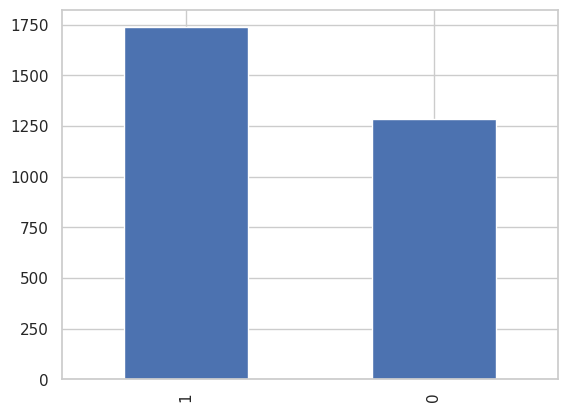

In [40]:
df['switch_well'].value_counts().plot(kind='bar')

#### Plot each input numerical variable vs. switch_well

We want to investigate whether the probability of switching wells is a clear function of the input numerical variables. 

$\rightarrow$ Make scatter plots of `switch_well` vs. each of the input numerical variables. Include jitter to make the points visible.


Plot the `arsenic` concentration vs. the `switch_well` variable.

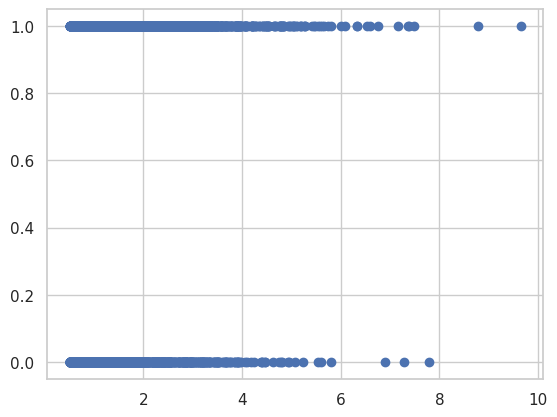

In [41]:
plt.plot(df['arsenic'], df['switch_well'], 'o')

Plot the distance to the nearest well (in 100 meters) vs. the `switch_well` variable.

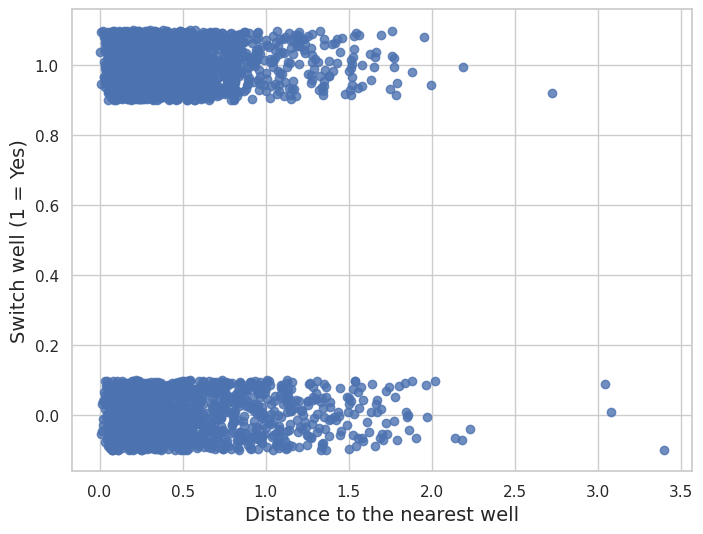

In [42]:
plt.figure(figsize = (8,6))

sns.regplot(data = df, x = 'distance_100_meters', y = 'switch_well', ci = None, fit_reg=False, y_jitter = 0.1)

plt.xlabel('Distance to the nearest well', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

Plot the years of education vs. the `switch_well` variable.

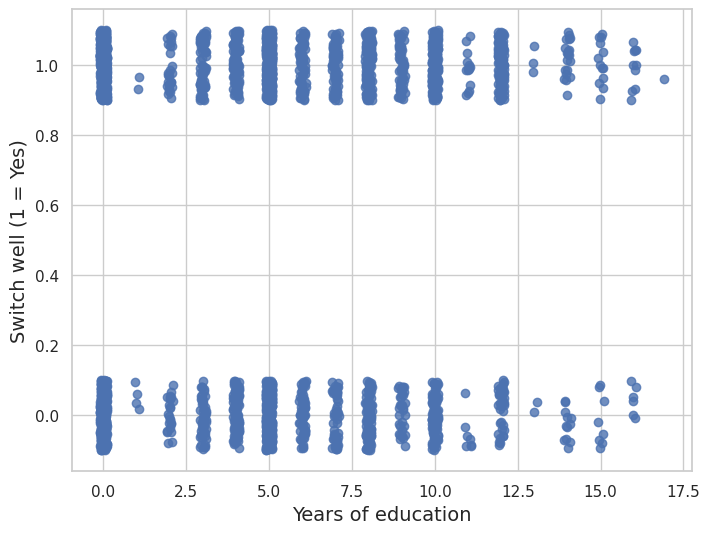

In [43]:
plt.figure(figsize = (8,6))

sns.regplot(data = df, x = 'education_years', y = 'switch_well', ci = None, fit_reg=False, y_jitter = 0.1, x_jitter = 0.1)

plt.xlabel('Years of education', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

$\rightarrow$ Count the number of switches for each value of `organization_member`. Additionally, calculate the proportion of switches for each value of `organization_member`.


In [44]:
df[['switch_well', 'organization_member']].groupby('organization_member').agg(['sum', 'mean'])

switch_well          
                            sum      mean
organization_member                      
0                          1029  0.590361
1                           708  0.554424

## Modeling

Note that linear regression does not produce a suitable model when the output variable is binary.

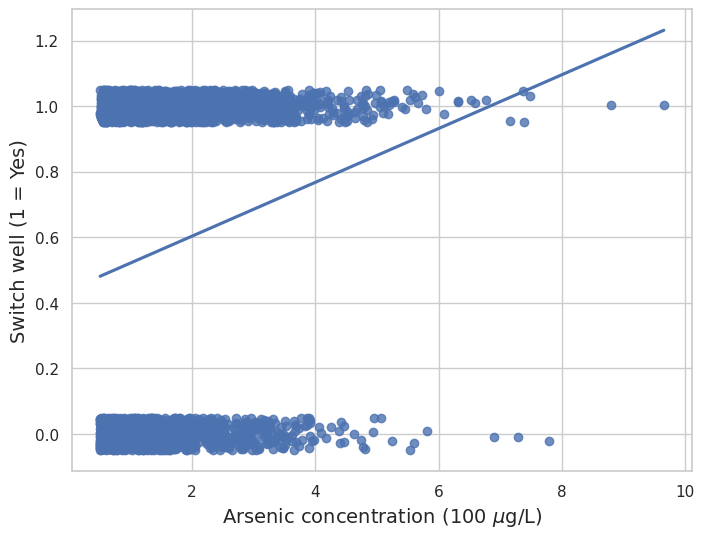

In [45]:
plt.figure(figsize = (8,6))

sns.regplot(data = df, x = 'arsenic', y = 'switch_well', ci = None, y_jitter = 0.05)

plt.xlabel('Arsenic concentration (100 $\mu$g/L)', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

In [46]:
df.head()

,switch_well,arsenic,distance_in_meters,organization_member,education_years,distance_100_meters
0,1,2.36,16.826000,0,0,0.16826
1,1,0.71,47.321999,0,0,0.47322
2,0,2.07,20.966999,0,10,0.20967
3,1,1.15,21.486000,0,12,0.21486
4,1,1.10,40.874001,1,14,0.40874


### Exploratory models

We will build models using the full data set to understand it more completely.

#### Logistic regression model for all predictors

##### $\rightarrow$ Fit the logistic regression model using all predictors, using the full data set. Examine the coefficients.

In [47]:
X = df.drop(columns=['switch_well', 'distance_in_meters'])

y = df['switch_well']

In [48]:
log_reg_all = sm.Logit(y, sm.add_constant(X)).fit()

Optimization terminated successfully.
         Current function value: 0.646991
         Iterations 5


In [89]:
print(log_reg_all.summary())

                           Logit Regression Results                           
Dep. Variable:            switch_well   No. Observations:                 2416
Model:                          Logit   Df Residuals:                     2411
Method:                           MLE   Df Model:                            4
Date:                Mon, 05 Jun 2023   Pseudo R-squ.:                 0.05583
Time:                        20:27:29   Log-Likelihood:                -1554.6
converged:                       True   LL-Null:                       -1646.5
Covariance Type:            nonrobust   LLR p-value:                 1.110e-38
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1654      0.112     -1.479      0.139      -0.385       0.054
arsenic                 0.4782      0.046     10.307      0.000       0.387       0.569
organization_mem

##### $\rightarrow$ Predict the well switching in the data

In [49]:
log_reg_all.predict(sm.add_constant(X))

0       0.688835
1       0.438024
2       0.740122
3       0.667563
4       0.613178
          ...   
3015    0.500176
3016    0.539684
3017    0.545420
3018    0.516202
3019    0.513165
Length: 3020, dtype: float64

In [50]:
pred_switch = round(log_reg_all.predict(sm.add_constant(X)))

In [51]:
class_names = ['not_switched', 'switch']

##### $\rightarrow$ Show the confusion matrix to visualize the errors.

Text(108.24687499999997, 0.5, 'predicted label')

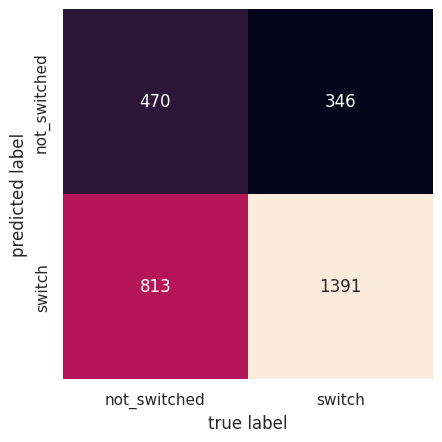

In [52]:
sns.heatmap(confusion_matrix(y, pred_switch).T, square=True, annot=True, cbar= False, fmt = 'g',
            xticklabels = class_names, yticklabels = class_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

##### $\rightarrow$ Compute the model accuracy.

In [53]:
confusion_matrix(y, pred_switch).T

array([[ 470,  346],
       [ 813, 1391]])

In [54]:
print(classification_report(y, pred_switch, target_names = class_names))

              precision    recall  f1-score   support

not_switched       0.58      0.37      0.45      1283
      switch       0.63      0.80      0.71      1737

    accuracy                           0.62      3020
   macro avg       0.60      0.58      0.58      3020
weighted avg       0.61      0.62      0.60      3020



 The model performs better in correctly identifying instances in the "switch" class compared to the "not_switched" class. It achieves a precision of 0.63 for the "switch" class, indicating that 63% of instances predicted as "switch" were correct. The recall for this class is 0.80, meaning that 80% of actual "switch" instances were correctly identified. The F1-score for the "switch" class is 0.71, representing a balanced measure of precision and recall.
However, the model's performance in the "not_switched" class is relatively weaker, with a precision of 0.58, indicating that 58% of instances predicted as "not_switched" were correct, and a lower recall of 0.37, indicating that only 37% of actual "not_switched" instances were correctly identified. The F1-score for this class is 0.45.
The overall accuracy of the model is 0.62, suggesting that 62% of instances were correctly classified. The macro average metrics, taking into account both classes, are 0.60 for precision, 0.58 for recall, and 0.58 for the F1-score. The weighted average metrics, considering the class imbalance, are 0.61 for precision, 0.62 for recall, and 0.60 for the F1-score.

#### Null model

The null model prediction always predicts the value of `switch_well` that occurs most often in the training data.


$\rightarrow$ What is the null model prediction for `switch_well`?





In [55]:
null_prediction = np.ones(np.shape(y))

$\rightarrow$ What is the accuracy of the null model on the full data set?


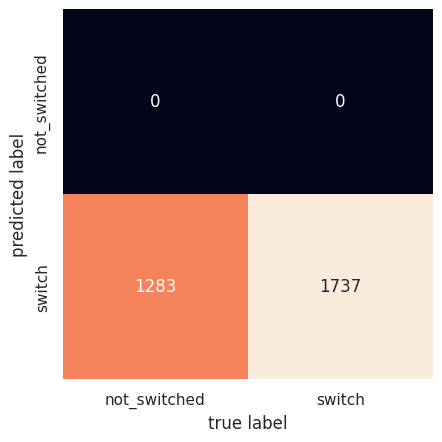

In [56]:
sns.heatmap(confusion_matrix(y, null_prediction).T, square=True, annot=True, cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [57]:
print(classification_report(y, null_prediction, target_names=class_names))

              precision    recall  f1-score   support

not_switched       0.00      0.00      0.00      1283
      switch       0.58      1.00      0.73      1737

    accuracy                           0.58      3020
   macro avg       0.29      0.50      0.37      3020
weighted avg       0.33      0.58      0.42      3020



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 The classification report evaluates the performance of a model that makes null predictions, where it predicts the same class for all instances. The model shows extremely poor performance in correctly identifying instances in the "not_switched" class, with zero precision, recall, and F1-score for that class. This means that none of the instances predicted as "not_switched" were correct, and none of the actual "not_switched" instances were correctly identified. On the other hand, the model performs reasonably well in identifying instances in the "switch" class, with a precision of 0.58, indicating that 58% of instances predicted as "switch" were correct, and a recall of 1.00, meaning that all actual "switch" instances were correctly identified. The F1-score for this class is 0.73, representing a balanced measure of precision and recall. However, the overall accuracy of the model is 0.58, indicating that only 58% of instances were correctly classified. 

### Simple logistic regression models

#### Fit a model with distance as the predictor




$\rightarrow$ Fit a logistic regression model with distance (in 100s of meters) as the predictor and examine the model.

In [58]:
X = df[['distance_100_meters']]

y = df['switch_well']

In [59]:
log_reg_distance = sm.Logit(y, sm.add_constant(X)).fit()

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4


In [90]:
print(log_reg_distance.summary())

                           Logit Regression Results                           
Dep. Variable:            switch_well   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3018
Method:                           MLE   Df Model:                            1
Date:                Mon, 05 Jun 2023   Pseudo R-squ.:                 0.01017
Time:                        20:30:11   Log-Likelihood:                -2038.1
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 9.798e-11
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6060      0.060     10.047      0.000       0.488       0.724
distance_100_meters    -0.6219      0.097     -6.383      0.000      -0.813      -0.431


$\rightarrow$ Plot the distance to the nearest well (in 100 meters) vs. the `switch_well` variable and include the logistic regression model.

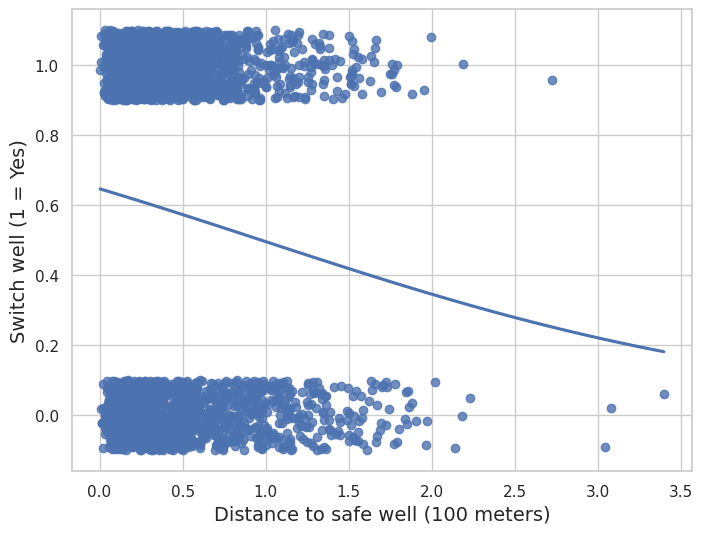

In [60]:
plt.figure(figsize = (8,6))

sns.regplot(data = df, 
            x = 'distance_100_meters', y = 'switch_well', 
            ci = None, y_jitter = 0.1, logistic=True)

plt.xlabel('Distance to safe well (100 meters)', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

In [61]:
-.6219/4

-0.155475

In [62]:
1/(1 + np.exp(-.606))

0.6470278089459086

$\rightarrow$ Interpret the value of $\hat{\beta}_0$.


The estimated probability $$P(\text{switch_well} = 1|\text{distance} = 0) = \frac{1}{1 + e^{-\hat{\beta}_0}} = \frac{1}{1 + e^{-0.61}} = 0.65$$

$\rightarrow$ Interpret the value of $\hat{\beta}_1$ by discussing its sign and what it says about the maximum rate of change of the probability of switching.


$\hat{\beta}_1 < 0$, so an increase in distance to the nearest safe well is associated with a decrease in probability of switching wells.


The maximum rate of change of the probability of switching is

$$\frac{\hat{\beta}_1}{4} = \frac{-0.62}{4} = -0.155$$
At the point of maximum rate of change of the probability of switching, a 100 meter increase in the distance to the nearest safe well corresponds to a decrease in probability of switching of about 16%

##### $\rightarrow$ Predict the well switching in the data

In [63]:
pred_switch_distance = round(log_reg_distance.predict(sm.add_constant(X)))

##### $\rightarrow$ Show the confusion matrix to visualize the errors.

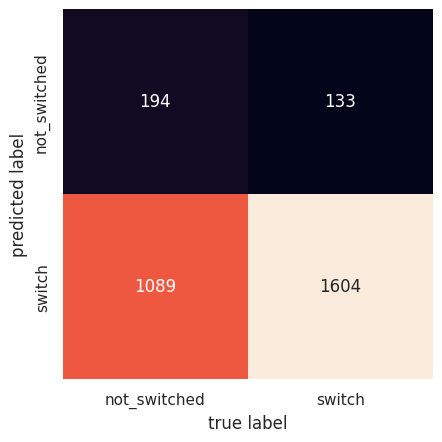

In [64]:
sns.heatmap(confusion_matrix(y, pred_switch_distance).T, square=True, annot=True, 
            cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy.

In [65]:
print(classification_report(y, pred_switch_distance, target_names=class_names))

              precision    recall  f1-score   support

not_switched       0.59      0.15      0.24      1283
      switch       0.60      0.92      0.72      1737

    accuracy                           0.60      3020
   macro avg       0.59      0.54      0.48      3020
weighted avg       0.59      0.60      0.52      3020



The model demonstrates better performance in correctly identifying instances in the "switch" class compared to the "not_switched" class. It achieves a precision of 0.60 for the "switch" class, indicating that 60% of instances predicted as "switch" were correct. The recall for this class is 0.92, meaning that 92% of actual "switch" instances were correctly identified. The F1-score for the "switch" class is 0.72, representing a balanced measure of precision and recall.
However, the model's performance in the "not_switched" class is relatively poor, with a precision of 0.59, indicating that 59% of instances predicted as "not_switched" were correct, and a low recall of 0.15, indicating that only 15% of actual "not_switched" instances were correctly identified. The F1-score for this class is 0.24.
The overall accuracy of the model is 0.60, suggesting that 60% of instances were correctly classified. 

#### Fit a model with distance and arsenic as predictors

Fit the model and examine the coefficients.


In [66]:
X = df[['distance_100_meters', 'arsenic']]

In [67]:
log_reg_distance_arsenic = sm.Logit(y, sm.add_constant(X)).fit()

Optimization terminated successfully.
         Current function value: 0.650773
         Iterations 5



$\rightarrow$ Why did the coefficient for `distance` change when arsenic was added?


There is a correlation between distance and arsenic concentration.

$\rightarrow$ Plot the decision boundary on a scatter plot of distance vs. arsenic, with point colored by switch.

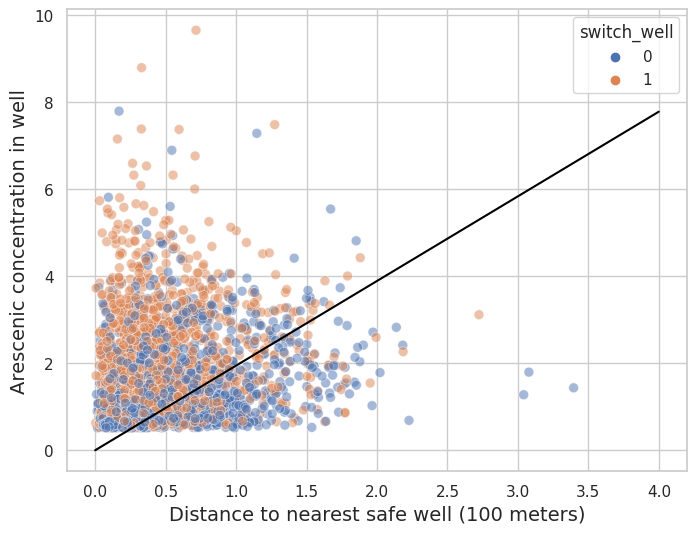

In [68]:
plt.figure(figsize = (8,6))

sns.scatterplot(data = df, x = 'distance_100_meters', y = 'arsenic', hue = 'switch_well', alpha = 0.5, s = 50);

# Set up plotting the decision boundary
#a, b, c = log_reg_distance_arsenic.intercept_[0], log_reg_distance_arsenic.coef_[0][0], log_reg_distance_arsenic.coef_[0][1]
a, b, c = log_reg_distance_arsenic.params.values
x_boundary = np.linspace(0,4,100)
y_boundary = (-a - b*x_boundary)/c

plt.plot(x_boundary, y_boundary, color = 'black')

plt.xlabel('Distance to nearest safe well (100 meters)', fontsize = 14)
plt.ylabel('Arescenic concentration in well', fontsize = 14);

##### $\rightarrow$ Predict the well switching in the data

In [69]:
pred_switch_distance_arsenic = round(log_reg_distance_arsenic.predict(sm.add_constant(X)))

##### $\rightarrow$ Show the confusion matrix to visualize the errors.

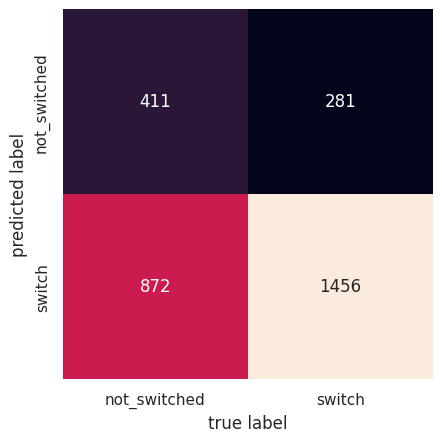

In [70]:
sns.heatmap(confusion_matrix(y, pred_switch_distance_arsenic).T, square=True, annot=True, cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy.

In [71]:
print(classification_report(y, pred_switch_distance_arsenic, target_names=class_names))

              precision    recall  f1-score   support

not_switched       0.59      0.32      0.42      1283
      switch       0.63      0.84      0.72      1737

    accuracy                           0.62      3020
   macro avg       0.61      0.58      0.57      3020
weighted avg       0.61      0.62      0.59      3020



## Compare models

We will use logistic regression and XGBoost to construct models that predict the probability of switching wells.

To compare the different approaches, we will use a training and testing split of the data set.


##### $\rightarrow$ Split the data into training and testing sets. Keep 20% of the data for the test set.

In [72]:
X = df.drop(columns = ['switch_well', 'distance_in_meters'])

y = df['switch_well']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [74]:
print(X_train.shape, X_test.shape)

(2416, 4) (604, 4)


##### $\rightarrow$ Create an input $X$ with all predictors.

In [75]:
X_train.agg(['mean', 'std', 'max', 'min'])

,arsenic,organization_member,education_years,distance_100_meters
mean,1.675004,0.426738,4.842715,0.486123
std,1.123177,0.494706,4.017572,0.386724
max,9.650000,1.000000,17.000000,3.395310
min,0.510000,0.000000,0.000000,0.003870


In [76]:
y_train.mean()

0.5761589403973509

In [77]:
y_test.mean()

0.5711920529801324

##### $\rightarrow$ Check that the training and testing input numerical variables have similar means and standard deviations.

### Null model 

The null model prediction always predicts the value of `switch_well` that occurs most often in the training data.


$\rightarrow$ What is the null model prediction for `switch_well` based on the training data?


In [78]:
null_prediction = np.ones(np.shape(y_test))

$\rightarrow$ What is the accuracy of the null model on the test data set?


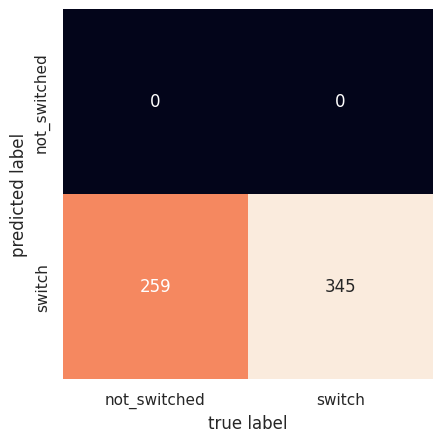

In [79]:
sns.heatmap(confusion_matrix(y_test, null_prediction).T, square=True, annot=True, cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [80]:
print(classification_report(y_test, null_prediction, target_names=class_names))

              precision    recall  f1-score   support

not_switched       0.00      0.00      0.00       259
      switch       0.57      1.00      0.73       345

    accuracy                           0.57       604
   macro avg       0.29      0.50      0.36       604
weighted avg       0.33      0.57      0.42       604



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The results of the null prediction model indicate a low performance in terms of classification. The accuracy of the model is 57% on the provided test data. However, it's important to note that the precision, recall, and f1-score for the "not_switched" class are all 0, indicating that the model failed to correctly identify any instances of this class. On the other hand, the precision for the "switch" class is 57%, suggesting that the model was able to identify instances of this class, but the recall and f1-score are both 100%, indicating that it may have incorrectly labeled some instances as belonging to this class.

### Logistic regression model


#### Logistic regression model for all predictors

##### $\rightarrow$ Fit the logistic regression model using all predictors, using the training data.

In [81]:
log_reg_all = sm.Logit(y_train, sm.add_constant(X_train)).fit()

Optimization terminated successfully.
         Current function value: 0.643453
         Iterations 5


In [97]:
print(log_reg_all.summary())

                           Logit Regression Results                           
Dep. Variable:            switch_well   No. Observations:                 2416
Model:                          Logit   Df Residuals:                     2411
Method:                           MLE   Df Model:                            4
Date:                Mon, 05 Jun 2023   Pseudo R-squ.:                 0.05583
Time:                        21:21:38   Log-Likelihood:                -1554.6
converged:                       True   LL-Null:                       -1646.5
Covariance Type:            nonrobust   LLR p-value:                 1.110e-38
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1654      0.112     -1.479      0.139      -0.385       0.054
arsenic                 0.4782      0.046     10.307      0.000       0.387       0.569
organization_mem

##### $\rightarrow$ Predict the well switching in the test data.

In [99]:
pred_switch_log_reg = round(log_reg_all.predict(sm.add_constant(X_test)))

##### $\rightarrow$ Show the confusion matrix to visualize the errors.

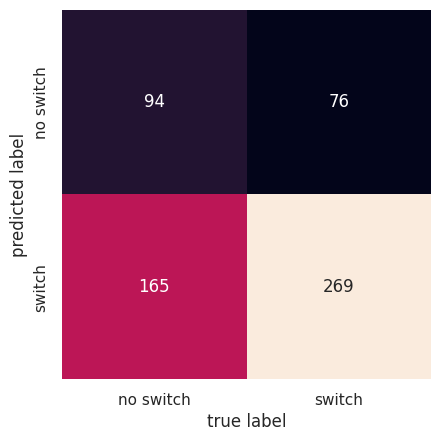

In [100]:
sns.heatmap(confusion_matrix(y_test, pred_switch_log_reg).T, 
            square=True, annot=True, cbar=False, fmt='g', 
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy, sensitivity, and specificity.

In [101]:
print(classification_report(y_test, pred_switch_log_reg, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.55      0.36      0.44       259
      switch       0.62      0.78      0.69       345

    accuracy                           0.60       604
   macro avg       0.59      0.57      0.56       604
weighted avg       0.59      0.60      0.58       604



The logistic regression model achieved an accuracy of 60% in predicting the classes "no switch" and "switch" based on the provided test data. The precision for the "no switch" class was 55% and the recall was 36%, while for the "switch" class, the precision was 62% and the recall was 78%. The f1-score for the "no switch" class was 0.44 and for the "switch" class was 0.69. 

### XGBoost


Compare the model accuracy to an XGBoost model on the same train/test split.

$\rightarrow$ Use 5-fold cross-validation to determine the hyperparameters of the XGBoost model.


In [82]:
xgb_model = xgb.XGBClassifier()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2,6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}
search = RandomizedSearchCV(xgb_model, param_distributions=params,
                            n_iter=200, cv=5, verbose=1,
                            n_jobs=1, return_train_score=True)
search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb979bf3790>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb979bf1600>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb979bf20b0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb979bf2dd0>},
                   return_train_score=True, verbose=1)

$\rightarrow$ Fit the model using the best parameters on the training data.

In [83]:
xgb_model = xgb.XGBClassifier()
xgb_model.set_params(**search.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7026986794881356, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.26649828558356137, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05402305111251779, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=111, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [84]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7026986794881356, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.26649828558356137, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05402305111251779, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=111, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

##### $\rightarrow$ Plot the feature importances using `gain` to determine importance.

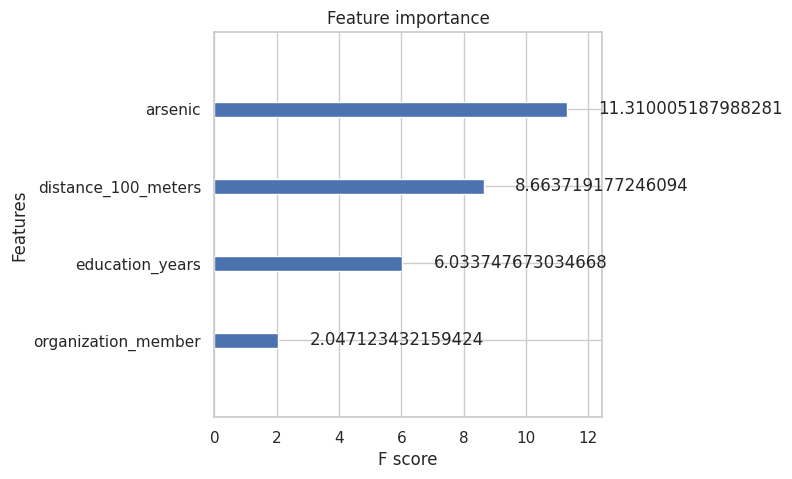

In [85]:
fig, ax = plt.subplots(figsize = (5,5))
xgb.plot_importance(xgb_model, ax = ax, importance_type='gain');

##### $\rightarrow$ Predict the well switching in the test data.

In [86]:
pred_mgb = xgb_model.predict(X_test)

##### $\rightarrow$ Show the confusion matrix to visualize the errors.

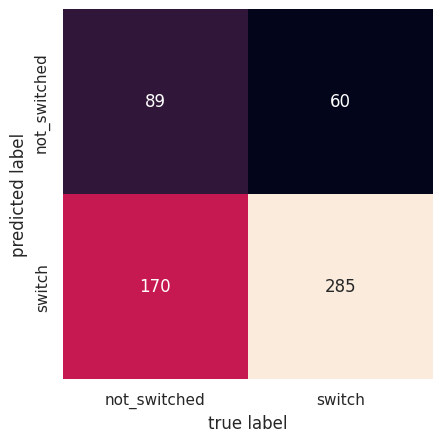

In [87]:
sns.heatmap(confusion_matrix(y_test, pred_mgb).T, square=True, annot=True, 
            cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy, sensitivity, and specificity.

In [102]:
xgb_model.score(X_test, y_test).round(2)

0.62

In [88]:
print(classification_report(y_test, pred_mgb, target_names=class_names))

              precision    recall  f1-score   support

not_switched       0.60      0.34      0.44       259
      switch       0.63      0.83      0.71       345

    accuracy                           0.62       604
   macro avg       0.61      0.58      0.57       604
weighted avg       0.61      0.62      0.59       604



The XGBoost model produced an overall accuracy of 62% in predicting the classes "not_switched" and "switch" based on the given test data. The precision for the "not_switched" class was 60% and the recall was 34%, while for the "switch" class, the precision was 63% and the recall was 83%. The f1-score for the "not_switched" class was 0.44 and for the "switch" class was 0.71. 

### Test different models

#### Lasso Regression

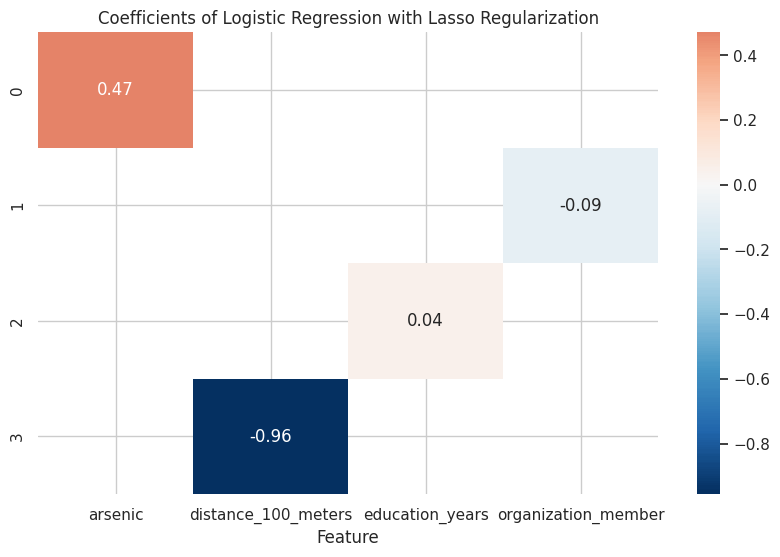

In [109]:
# Fit the logistic regression model with L1 penalty
log_reg_lasso = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_lasso.fit(X_train, y_train)

# Extract the coefficients and feature names
coefficients = log_reg_lasso.coef_.ravel()
feature_names = X_train.columns

# Create a dataframe with coefficients and feature names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Reshape the coefficients into a 2D array for heatmap
coef_matrix = coef_df.pivot(index=None, columns='Feature', values='Coefficient')

# Create a heatmap of the coefficients
plt.figure(figsize=(10, 6))
sns.heatmap(coef_matrix, cmap='RdBu_r', center=0, annot=True, fmt=".2f")
plt.title('Coefficients of Logistic Regression with Lasso Regularization')
plt.show()

 Arsenic (0.47), Distance to Closest Well (100 meters) (-0.96), Education Years (0.04), and Organization Membership (-0.09). These coefficients indicate the impact of each feature on the likelihood of switching wells. Higher levels of arsenic and more years of education are positively associated with switching wells, while greater distances to the closest well and household membership in community organizations are negatively associated with switching wells.

In [110]:
# Create the ridge logistic regression model
ridge_log_reg = LogisticRegression(penalty='l2', solver='liblinear')

# Fit the model to the training data
ridge_log_reg.fit(X_train, y_train)

# Predict the classes for the test data
pred_ridge_log_reg = ridge_log_reg.predict(X_test)

# Print the classification report
print(classification_report(y_test, pred_ridge_log_reg, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.55      0.36      0.44       259
      switch       0.62      0.78      0.69       345

    accuracy                           0.60       604
   macro avg       0.59      0.57      0.56       604
weighted avg       0.59      0.60      0.58       604



The ridge logistic regression model achieved similar results to the previous logistic regression model. The accuracy of the ridge logistic regression model was 60% on the provided test data. The precision for the "no switch" class was 55% and the recall was 36%, while for the "switch" class, the precision was 62% and the recall was 78%. The f1-score for the "no switch" class was 0.44 and for the "switch" class was 0.69. These metrics provide an evaluation of the model's performance in terms of classification accuracy and the ability to correctly identify samples in each class.

# Conclusion

In conclusion, we have conducted an analysis using various machine learning models to predict the switching behavior of households in relation to well usage for drinking water. We explored models such as logistic regression, lasso regression, ridge regression, and XGBoost.

Overall, our results showed varying levels of performance across the different models. The logistic regression model achieved an accuracy of 60% on the test data, with a higher precision and recall for the "switch" class compared to the "not_switched" class. The lasso regression model identified the importance of variables such as arsenic levels, distance to the closest safe well, education years, and organization membership in predicting the switching behavior. Ridge regression produced similar results to logistic regression, indicating the significance of these variables in determining well-switching decisions.

Furthermore, the XGBoost model demonstrated better performance with an accuracy of 62% and higher precision and recall for the "switch" class. This suggests that XGBoost might be a suitable model for predicting well-switching behavior in this context. 

In summary, our analysis provides insights into the factors influencing well-switching decisions in relation to drinking water quality. 